In [1]:
import os
import sys
import pandas as pd 
import random
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection as fdr
sys.path.append('..')
import abd_profile
import numpy as np
import se
import tree_util
import copy
from scipy import stats
random.seed(0)

In [2]:
def fr(d_df, profile, sname):
    #print(profile.columns, d_df.index)
    sp_list = sorted(list(set(profile.columns).intersection(set(d_df.index))))
    #print(sp_list)
    sp_d_df = d_df.loc[sp_list, sp_list]
    #print(profile)
    sp_profile = np.array(profile.loc[sname, sp_list])
    value = np.dot(sp_profile.reshape(len(sp_profile), 1),sp_profile.reshape(1, len(sp_profile)))
    width = value.shape[0]
    cor_df = np.ones(shape=(width, width)) - sp_d_df.values
    for i in range(width):
        cor_df[i][i] = 0
    value = np.multiply(value, cor_df)
    fr_df = pd.DataFrame(value, index=sp_list, columns=sp_list)
    return fr_df

def select_edges_assign(df, pairs, remaining_pairs, nsample=200):
    triu_indices = np.triu_indices_from(df, k=1)
    upper_triangle_values = df.values[triu_indices]
    #print(upper_triangle_values)
    #samples = random.sample(upper_triangle_values.value(), nsample)
    samples = sorted(list(upper_triangle_values), reverse=True)[:nsample]
    
    # random put into the new_df
    new_df = pd.DataFrame(index=df.index, columns=df.columns, data=0)
    #upper_triangle_pairs = [(df.index[i], df.columns[j]) for i, j in zip(*triu_indices)]
    upper_triangle_pairs = pairs + remaining_pairs
    sample_pairs = random.sample(upper_triangle_pairs, nsample)
    for idx, (i, j) in enumerate(sample_pairs):
        new_df.loc[i, j] = samples[idx]
    rand_df = copy.deepcopy(new_df+new_df.T)
    
   
    # random put into the pairs
    new_df = pd.DataFrame(index=df.index, columns=df.columns, data=0)
    sample_pairs = random.sample(pairs, nsample)
    for idx, (i, j) in enumerate(sample_pairs):
        new_df.loc[i, j] = samples[idx]
    in_df = copy.deepcopy(new_df+new_df.T)

    # random put outside the pairs
    new_df = pd.DataFrame(index=df.index, columns=df.columns, data=0)
    sample_pairs = random.sample(remaining_pairs, nsample)
    for idx, (i, j) in enumerate(sample_pairs):
        new_df.loc[i, j] = samples[idx]
    out_df = copy.deepcopy(new_df+new_df.T)
    return rand_df, in_df, out_df



In [3]:
# n: repeat time
# k: sample number

def summary(se_list_rand, se_list_high, se_list_low):
    
    # run paired Wilcoxon test
    statistic, p1 = stats.wilcoxon(se_list_high, se_list_rand)
    statistic, p2 = stats.wilcoxon(se_list_low, se_list_rand)
    statistic, p3 = stats.wilcoxon(se_list_high, se_list_low)
    print("rand mean: ", np.mean(se_list_rand), 'rand std: ', np.std(se_list_rand))
    print("high mean: ", np.mean(se_list_high), 'high std: ', np.std(se_list_high))
    print("low mean: ", np.mean(se_list_low), 'low std: ', np.std(se_list_low))
    print("rand vs high: ", p1)
    print("rand vs low: ", p2)
    print("high vs low: ", p3)

def get_ori_nets(profile, d_df):
    net_dict = {}
    rename_dict = {}
    for sp in d_df.index:
        rename_dict[sp] = sp.replace('_', '-')
    renamed_d = d_df.rename(columns=rename_dict, index=rename_dict)

    renamed_profile = profile.rename(columns=rename_dict)
    renamed_profile = renamed_profile[list(set(renamed_profile.columns).intersection(set(renamed_d.index)))]
    for sname in profile.index:
        # print(sname)
        edge_df = fr(renamed_d, renamed_profile, sname)
        net_dict[sname] = copy.deepcopy(edge_df)
        # tmp = se.subtree_se_adj(edge_df, parent_dict, node_leaves, subtree_nodes, direct_children_dict, param)
        # for node in tmp.keys():
        #     value = tmp[node]
        #     result.loc[sname, node] = value
    return net_dict

def split_newick(newick_tree):
    json_tree = tree_util.parse(newick_tree)
    largest = {'largest': 0}
    leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
    largest_level = largest['largest']
    nlayer = largest_level
    leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
    layer_leaves_dict = tree_util.make_layer_dict(nlayer)

    tree_util.recu_layer(json_tree, layer_leaves_dict)
    tree_util.to_layer_leaves(layer_leaves_dict, nlayer)
    result = {}
    # compute leaf layer
    result['leaves_dict'] = copy.deepcopy(layer_leaves_dict)
    parent_dict = {}
    tree_util.parents(json_tree, parent_dict)
    node_leaves = {}
    for level in layer_leaves_dict.keys():
        for node, sp_list in layer_leaves_dict[level].items():
            if node in node_leaves.keys():
                continue
            node_leaves[node] = copy.deepcopy(sp_list)
    subtree_nodes = {}
    for l in leaf_list:
        parent = parent_dict[l]
        if parent not in subtree_nodes.keys():
            subtree_nodes[parent] = []
        subtree_nodes[parent].append(l)

    for node in node_leaves.keys():
        parent = parent_dict[node]
        if parent not in subtree_nodes.keys():
            subtree_nodes[parent] = []
        subtree_nodes[parent] += subtree_nodes[node]
        subtree_nodes[parent].append(node)

    for node in subtree_nodes.keys():
        subtree_nodes[node].append(node)

    direct_children_dict = {}
    for node, parent in parent_dict.items():
        if parent not in direct_children_dict:
            direct_children_dict[parent] = []
        direct_children_dict[parent].append(node)
    return parent_dict, node_leaves, subtree_nodes, direct_children_dict, leaf_list

def get_se_list(net_dict, parent_dict, node_leaves, subtree_nodes, direct_children_dict, param=0.5):
    result = pd.DataFrame()
    for sname in net_dict.keys():
        edge_df = net_dict[sname]
        # for i, edge_df in enumerate(net_dict[sname]):
        #     nid = "{}_{}".format(sname, i)
        nid = sname
        tmp = se.subtree_se_adj(edge_df, parent_dict, node_leaves, subtree_nodes, direct_children_dict, param)
        for node in tmp.keys():
            value = tmp[node]
            result.loc[nid, node] = value
    return result


def read_cohort(indir, sedir):
    # Load the dataset
    abd_path = os.path.join(indir, 'abd.tsv')
    metadata_path = os.path.join(indir, 'metadata.tsv')
    # first process data from gutmeta
    raw_profile = abd_profile.input_profile(abd_path, transfer=True)
    metadata = pd.read_csv(metadata_path, sep='\t', header=0)
    selected_raw_profile = raw_profile.loc[list(metadata['sample_id']), :]
    selected_raw_profile = abd_profile.rename_s_level(selected_raw_profile)
    crc_profile = abd_profile.clean(selected_raw_profile)

    pheno_list = {}
    for i in range(metadata.shape[0]):
        pheno = metadata.loc[i, 'disease']
        if pheno not in pheno_list.keys():
            pheno_list[pheno] = []
        if metadata.loc[i, 'sample_id'] in list(crc_profile.index):
            pheno_list[pheno].append(metadata.loc[i, 'sample_id'])

    # se_dict = {}
    # for c in pheno_list.keys():
    #     se_dict[c] = pd.read_csv(os.path.join(sedir, 'se_{}.tsv'.format(c)), sep='\t', header=0, index_col=0)

    # se_df = pd.DataFrame()
    # for c in pheno_list.keys():
    #     se_df = pd.concat([se_df, se_dict[c]], axis=0)

    # #slist = pheno_list['Health']
    return crc_profile
    # return crc_profile[sorted(crc_profile.columns)], se_df.loc[slist, ]

def sampling(total, cluster_list, slist):
    clusters = random.choices(cluster_list, k=total)
    samples = random.choices(slist, k=total)
    return samples, clusters

def sampling_s(total, slist):
    samples = random.choices(slist, k=total)
    return samples

In [15]:
outer_dir = '../data'
total_time = 10
outer_se = '../result/GCN_fix_tree/SE/GCN_tree_diff'
output_dir = '../result/validation/se_related_3'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# abd_dff_dir = '../result/taxa_abd_check'
plist = ['CRC', 'IBD', 'T2D']
plist = ['CRC']
d_df = pd.read_csv('../data/sp_d.tsv', sep='\t', header=0, index_col=0)
diff_df = pd.read_csv('../result/GCN_fix_tree/SE/GCN_tree_diff/p_all_cohorts.tsv', sep='\t', header=0, index_col=0)
with open('../result/GCN_fix_tree/renamed_GCN_tree.newick') as fp:
    newick_tree = fp.read()
    parent_dict, node_leaves, subtree_nodes, direct_children_dict, leaf_list = split_newick(newick_tree)
pheno_result= {}
ori_se_dict = {}


In [16]:
cluster = 'supercluster_S1'
nsample = 189000
for pheno in plist:
    result = pd.DataFrame(columns = ['sample', 'cluster', 'rand', 'high', 'low'])
    data_dir = os.path.join(outer_dir, pheno)
    se_dir = os.path.join(outer_se, pheno)
    print('== {} =='.format(pheno))
    merged_crc_profile = pd.DataFrame()
    for cohort in os.listdir(data_dir):
        print(f'-- {pheno} -- {cohort} --')
        # sp_diff_df = pd.read_csv(os.path.join(abd_dff_dir, pheno, 'p_{}.tsv'.format(cohort)), sep='\t', header=0, index_col=0)
        se_cohort_dir = os.path.join(se_dir, cohort)
        #ori_se = pd.read_csv(os.path.join(se_cohort_dir, 'se_Health.tsv'), sep='\t', header=0, index_col=0)
        abd_dir = os.path.join(data_dir, cohort)
        #crc_profile, se_df = read_cohort(abd_dir, os.path.join(outer_se, pheno, cohort))
        crc_profile = read_cohort(abd_dir, os.path.join(outer_se, pheno, cohort))
        merged_crc_profile, crc_profile_tmp = merged_crc_profile.align(crc_profile, join='outer', fill_value=0)
        merged_crc_profile.loc[crc_profile.index, crc_profile.columns] = crc_profile
    #random sampling sample and cluster 
    #sub_slist, sub_clusters = sampling(total_sample, clusters, merged_crc_profile.index)  
    sub_slist = sampling_s(total_time, merged_crc_profile.index) 
    crc_profile = merged_crc_profile.loc[list(set(sub_slist)), ]
    crc_profile = crc_profile[list(set(crc_profile.columns).intersection(set(d_df.index)))]
    fr_dict = copy.deepcopy(get_ori_nets(crc_profile, d_df))
    renamed_dict = {}
    for sp in crc_profile.columns:
        renamed_dict[sp] = sp.replace('_', '-')
    crc_profile = crc_profile.rename(columns=renamed_dict)
    
    leaves = set(node_leaves[cluster]).intersection(set(crc_profile.columns))
    leaves = sorted(list(leaves))
    pairs = []
    for i in range(len(leaves)):
        for j in range(i+1, len(leaves)):
            pairs.append((leaves[i], leaves[j]))
    print('pairs: ', len(pairs))

    remaining_pairs = []
    for i in range(len(crc_profile.columns)):
        s1 = crc_profile.columns[i]
        for j in range(i+1, len(crc_profile.columns)):
            s2 = crc_profile.columns[j]
            if not ((s1 in leaves) and (s2 in leaves)):
                remaining_pairs.append((s1, s2))
    print('remaining pairs: ', len(remaining_pairs))
    rand_dict = {}
    high_dict = {}
    low_dict = {}
    for subid in range(len(sub_slist)):
        sample = sub_slist[subid]
        tmp_dict = {}
        tmp_dict[sample] = copy.deepcopy(fr_dict[sample])
        rand_df, in_df, out_df = select_edges_assign(fr_dict[sample], pairs, remaining_pairs, nsample)
        rand_dict[sample] = copy.deepcopy(rand_df)
        high_dict[sample] = copy.deepcopy(in_df)
        low_dict[sample] = copy.deepcopy(out_df)
    # rand_se = get_se_list(rand_dict, parent_dict, node_leaves, subtree_nodes, direct_children_dict)
    # high_se = get_se_list(high_dict, parent_dict, node_leaves, subtree_nodes, direct_children_dict)
    # low_se = get_se_list(low_dict, parent_dict, node_leaves, subtree_nodes, direct_children_dict)
    # for  nid in rand_se.index:
    #     result = result.append({'sample': nid, 'cluster': cluster, 'rand': rand_se.loc[nid, cluster], 'high': high_se.loc[nid, cluster], 'low': low_se.loc[nid, cluster]}, ignore_index=True)
    
    # tmp_dir = os.path.join(output_dir, pheno)
    # if not os.path.exists(tmp_dir):
    #     os.makedirs(tmp_dir)
    # result.to_csv(os.path.join(tmp_dir, 'se_summary.tsv'), sep='\t')
    # pheno_result[pheno] = copy.deepcopy(result)



== CRC ==
-- CRC -- CRC1 --
-- CRC -- CRC2 --
-- CRC -- CRC3 --
-- CRC -- CRC4 --
-- CRC -- CRC5 --
-- CRC -- CRC6 --
-- CRC -- CRC7 --
-- CRC -- CRC8 --
-- CRC -- CRC9 --
pairs:  191890
remaining pairs:  189611


In [17]:
rand_se = get_se_list(rand_dict, parent_dict, node_leaves, subtree_nodes, direct_children_dict)


In [18]:
high_se = get_se_list(high_dict, parent_dict, node_leaves, subtree_nodes, direct_children_dict)


In [19]:
low_se = get_se_list(low_dict, parent_dict, node_leaves, subtree_nodes, direct_children_dict)

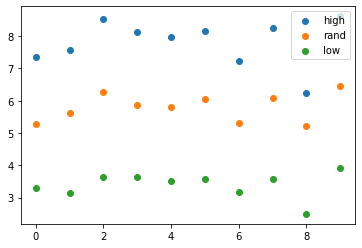

In [20]:
import matplotlib.pyplot as plt
plt.scatter(range(len(high_se)), high_se[cluster])
plt.scatter(range(len(rand_se)), rand_se[cluster])
plt.scatter(range(len(low_se)), low_se[cluster])
plt.legend(['high', 'rand', 'low'])

In [11]:
summary(rand_se[cluster], high_se[cluster], low_se[cluster])

rand mean:  5.470405970535876 rand std:  0.0
high mean:  7.540590931140479 high std:  0.0
low mean:  3.2464544830797135 low std:  0.0
rand vs high:  1.0
rand vs low:  1.0
high vs low:  1.0


In [12]:
# for pheno in plist:
#     result = pheno_result[pheno]
#     rand_se = result['rand']
#     high_se = result['high']
#     low_se = result['low']
#     summary(rand_se, high_se, low_se)

In [13]:
low_se

,cluster_S1-C1,cluster_S1-C2,cluster_S1-C3,cluster_S1-C4,cluster_S1-C5,cluster_S1-C6,cluster_S1-C7,cluster_S1-C8,cluster_S1-C9,cluster_S1-C10,...,cluster_C7,cluster_C8,cluster_C9,cluster_C10,supercluster_S1,supercluster_S2,supercluster_S3,supercluster_S4,supercluster_S5,supercluster_S6
SAMD00164938,0.253652,0.246818,0.280356,0.159395,0.352237,0.006709,0.008955,0.340951,0.122817,0.266321,...,0.195731,0.235521,0.033014,0.0,3.246454,1.171356,1.444991,0.223082,0.181365,0.855927


In [14]:
low_dict.keys()

dict_keys(['SAMD00164938'])